In [1]:
#need use car DEC environment 
"""Broadly useful python packages"""
import pandas as pd
import os
import sys
import numpy as np
import pickle
from copy import deepcopy
from shutil import move
import warnings
import tensorflow as tf
tf.keras.backend.clear_session()

"""Machine learning and single cell packages"""
import sklearn.metrics as metrics
from sklearn.metrics import adjusted_rand_score as ari, normalized_mutual_info_score as nmi
import scanpy as sc
import anndata
from anndata import AnnData


/home/xiaoxiang/anaconda3/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/xiaoxiang/.local/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
import platform
print("python version: "+platform.python_version())

python version: 3.6.8


In [3]:
print("The version of scanpy is:",sc.__version__)
print("The version of tensorflow is",tf.__version__)
print("The version of anndata is:",anndata.__version__)

The version of scanpy is: 1.4.4.post1
The version of tensorflow is 2.1.0
The version of anndata is: 0.7.1


In [4]:
"""CarDEC Package"""
carDEC_path="/home/xiaoxiang/Documents/carDEC_paper/CarDEC_new20200421/pyfiles"
if carDEC_path not in sys.path:
    sys.path.append(carDEC_path)
    
"""CarDEC Package"""
from CarDEC_API import CarDEC_API

In [5]:
"""Miscellaneous useful functions"""

def purity_score(y_true, y_pred):
    """A function to compute cluster purity"""
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)

    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)


def build_dir(dir_path):
    subdirs = [dir_path]
    substring = dir_path

    while substring != '':
        splt_dir = os.path.split(substring)
        substring = splt_dir[0]
        subdirs.append(substring)
        
    subdirs.pop()
    n = len(subdirs)
    subdirs = [subdirs[n - 1 - x] for x in range(n)]
    
    for dir_ in subdirs:
        if not os.path.isdir(dir_):
            os.mkdir(dir_)
    
def find_resolution(adata_, n_clusters, random = 0): 
    adata = adata_.copy()
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., 1000.]
    
    while obtained_clusters != n_clusters and iteration < 50:
        current_res = sum(resolutions)/2
        sc.tl.louvain(adata, resolution = current_res, random_state = random)
        labels = adata.obs['louvain']
        obtained_clusters = len(np.unique(labels))
        
        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res
        
        iteration = iteration + 1
        
    return current_res

metrics_ = [ari, nmi, purity_score]

In [6]:
"""
#read and save data
adata = sc.read("./raw_data/monocyte_desc_use.h5ad", cache=True)
adata
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=30)
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata = adata[adata.obs['percent_mito'] < 0.05, :]
adata.obs['BatchID'] = adata.obs['dataset_batch']
adata.write("dca_test.h5ad")
"""

"""Read and normalize the data"""
adata = sc.read("../../raw_data/monocyte_desc_use.h5ad", cache=True)
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=30) # must filter that genes with all zeros
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata = adata[adata.obs['percent_mito'] < 0.05, :]
adata.obs['BatchID'] = adata.obs['dataset_batch'].copy()
adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 10878 × 11160 
    obs: 'batch_label', 'cellname', 'dataset_batch', 'dataset_label', 'status_label', 'n_genes', 'n_counts', 'percent_mito', 'BatchID'
    var: 'genename', 'n_cells'

In [7]:
#create output dir
build_dir("CarDEC Results/results_k4")

In [8]:
CarDEC = CarDEC_API(adata, weights_dir = "CarDEC Results/results_k4", batch_key = "dataset_batch", n_high_var = 2000, LVG = True)

/home/xiaoxiang/anaconda3/envs/py36/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [9]:
CarDEC.dataset

AnnData object with n_obs × n_vars = 10878 × 11160 
    obs: 'batch_label', 'cellname', 'dataset_batch', 'dataset_label', 'status_label', 'n_genes', 'n_counts', 'percent_mito', 'BatchID', 'size factors', 'batch'
    var: 'genename', 'n_cells', 'n_counts', 'Variance Type'
    uns: 'num_batch'
    layers: 'normalized input'

In [10]:
#save the highly variable genes used
var_df0=CarDEC.dataset.var[['genename','Variance Type']]
var_df0['genename']=var_df0.index.copy()
var_df0.to_csv("CarDEC_hvg_used.tsv",index=False,sep="\t")

/home/xiaoxiang/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Fit the CarDEC Model (n_cluster=4)

In [11]:
CarDEC.build_model(n_clusters = 4,batch_size=256)
#Now, call the make_inference method to finetune CarDEC. 
CarDEC.make_inference()
#To get denoised features on the count scale, call the model_counts method.
CarDEC.model_counts()

Pretrain weight index file not detected, pretraining autoencoder weights.

Epoch 000: Training Loss: 1.004, Validation Loss: 1.018, Time: 0.8 s
Epoch 001: Training Loss: 1.002, Validation Loss: 1.005, Time: 0.8 s
Epoch 002: Training Loss: 0.996, Validation Loss: 1.013, Time: 0.8 s
Epoch 003: Training Loss: 0.993, Validation Loss: 1.006, Time: 0.8 s
Epoch 004: Training Loss: 0.988, Validation Loss: 1.002, Time: 0.8 s
Epoch 005: Training Loss: 0.987, Validation Loss: 1.007, Time: 0.8 s
Epoch 006: Training Loss: 0.984, Validation Loss: 0.999, Time: 0.8 s
Epoch 007: Training Loss: 0.983, Validation Loss: 0.994, Time: 0.8 s
Epoch 008: Training Loss: 0.981, Validation Loss: 1.004, Time: 0.8 s
Epoch 009: Training Loss: 0.982, Validation Loss: 0.991, Time: 0.8 s
Epoch 010: Training Loss: 0.980, Validation Loss: 0.994, Time: 0.9 s
Epoch 011: Training Loss: 0.978, Validation Loss: 0.999, Time: 0.8 s
Epoch 012: Training Loss: 0.977, Validation Loss: 1.005, Time: 0.8 s

Decaying Learning Rate to: 

/home/xiaoxiang/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)



 4 clusters detected. 


-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         multiple                  260256    
_________________________________________________________________
decoder (Sequential)         multiple                  262224    
_________________________________________________________________
encoderLVG (Sequential)      multiple                  1176736   
_________________________________________________________________
decoderLVG (Sequential)      multiple                  1189960   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  128       
Total params: 2,889,304
Trainable params: 2,889,304
Non-trainable params: 0
_________________________________________________________________

--------------

In [12]:
print("The overall structure of the output is: \n")
print(CarDEC.dataset)
CarDEC.dataset.X #The main layer of the output object contains the original counts
CarDEC.dataset.layers['denoised'] #These are the denoised features, on the zscore scale
CarDEC.dataset.layers['denoised counts'] #These are the denoised features, on the count scale
CarDEC.dataset.var['Variance Type'] #This is a vector that informs which genes are high variance and which are low variance
CarDEC.dataset.obsm['embedding'] #This is the CarDEC low-dimensional embedding after finetuning.
CarDEC.dataset.obsm['precluster denoised'] #This is the matrix of feature zscores denoised with the pretrained autoencoder.
CarDEC.dataset.obsm['precluster embedding'] #This is the latent embedding from the pretrained autoencoder.
CarDEC.dataset.obsm['initial assignments'] #This is a vector of cluster assignments from running louvain after the pretrain step

"""Example, this is how to get the matrix of denoised counts for only high variance genes"""
HVG_denoised = deepcopy(CarDEC.dataset.layers['denoised counts'][:, CarDEC.dataset.var['Variance Type'] == 'HVG'])

"""Example, this is how to get the matrix of denoised counts for only low variance genes"""
LVG_denoised = deepcopy(CarDEC.dataset.layers['denoised counts'][:, CarDEC.dataset.var['Variance Type'] == 'LVG'])

The overall structure of the output is: 

AnnData object with n_obs × n_vars = 10878 × 11160 
    obs: 'batch_label', 'cellname', 'dataset_batch', 'dataset_label', 'status_label', 'n_genes', 'n_counts', 'percent_mito', 'BatchID', 'size factors', 'batch'
    var: 'genename', 'n_cells', 'n_counts', 'Variance Type'
    uns: 'num_batch'
    obsm: 'cluster memberships', 'precluster denoised', 'embedding', 'precluster embedding', 'initial assignments', 'LVG embedding'
    layers: 'denoised', 'denoised counts'


In [13]:
CarDEC.dataset.write("CarDEC Results/adata_CarDEC.h5ad")

... storing 'Variance Type' as categorical


In [14]:
res0={}

## Working with the embedding and cluster assignments

... storing 'predicted' as categorical
... storing 'BatchID' as categorical


Done


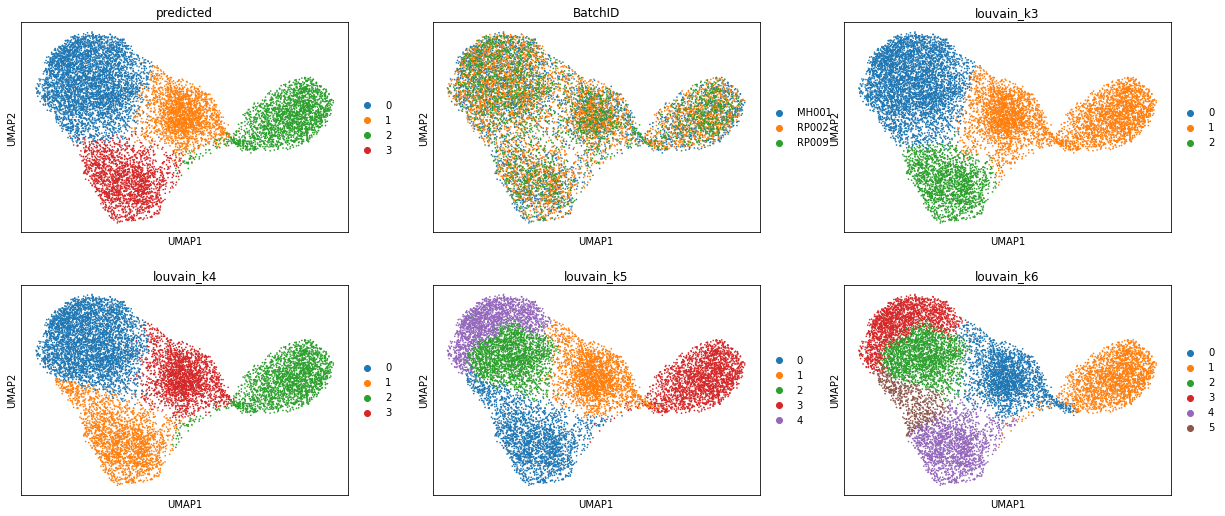

In [15]:
"""Create a scanpy AnnData object with the latent embedding as the matrix, to perform scanpy UMAP embedding"""
embedded = deepcopy(CarDEC.dataset.obsm['embedding']) #The latent embedding numpy array
q = deepcopy(CarDEC.dataset.obsm['cluster memberships']) #The cluster membership numpy array
labels = np.argmax(q, axis=1)
labels = [str(x) for x in labels]
formatting = AnnData(embedded)
formatting.obs["predicted"] = list(labels)
formatting.obs["BatchID"] = list(CarDEC.dataset.obs['BatchID'])

sc.pp.neighbors(formatting, n_neighbors = 15, use_rep = 'X')

res = find_resolution(formatting,3)
sc.tl.louvain(formatting, resolution = res)
formatting.obs['louvain_k3']=formatting.obs['louvain'].copy()
res = find_resolution(formatting, 4)
sc.tl.louvain(formatting, resolution = res)
formatting.obs['louvain_k4']=formatting.obs['louvain'].copy()
res = find_resolution(formatting, 5)
sc.tl.louvain(formatting, resolution = res)
formatting.obs['louvain_k5']=formatting.obs['louvain'].copy()
res = find_resolution(formatting, 6)
sc.tl.louvain(formatting, resolution = res)
formatting.obs['louvain_k6']=formatting.obs['louvain'].copy()

sc.tl.umap(formatting)
sc.pl.umap(formatting, color = ["predicted", "BatchID","louvain_k3", "louvain_k4","louvain_k5", "louvain_k6"],ncols=3, return_fig = True)
print("Done")

In [16]:
tmp0=formatting.obs[["predicted","BatchID",'louvain_k3',"louvain_k4","louvain_k5","louvain_k6"]].copy()
tmp0.columns=["latent_predicted","latent_BatchID",'louvain_k3',"louvain_k4","louvain_k5","louvain_k6"]
res0['latent embedding']=tmp0.copy()

... storing 'BatchID' as categorical


Done


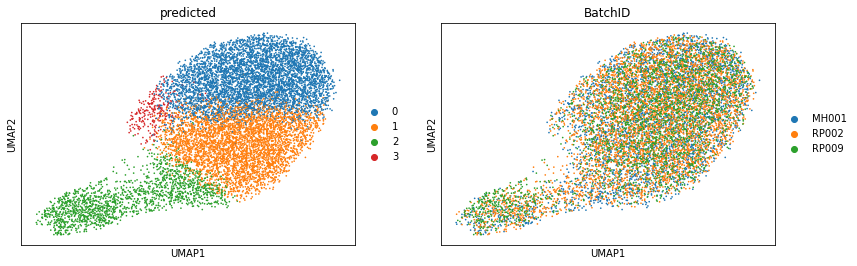

In [17]:
"""Create a scanpy AnnData object with the latent embedding as the matrix, to perform scanpy UMAP embedding"""
preclust_emb = deepcopy(CarDEC.dataset.obsm['precluster embedding'])
formatting = AnnData(preclust_emb)
sc.pp.neighbors(formatting, n_neighbors = 15, use_rep = 'X')
res = find_resolution(formatting, 4)
sc.tl.louvain(formatting, resolution = res)

formatting.obs["predicted"] = formatting.obs['louvain']
formatting.obs["BatchID"] = list(CarDEC.dataset.obs['BatchID'])

sc.pp.neighbors(formatting, n_neighbors = 15, use_rep = 'X')
sc.tl.umap(formatting)
sc.pl.umap(formatting, color = ["predicted", "BatchID"], return_fig = True)
print("Done")

In [18]:
tmp0=formatting.obs[["predicted","BatchID"]].copy()
tmp0.columns=["prelatent_predicted","prelatent_BatchID"]
res0['prelatent embedding']=tmp0.copy()

## Working with the denoised counts

Done


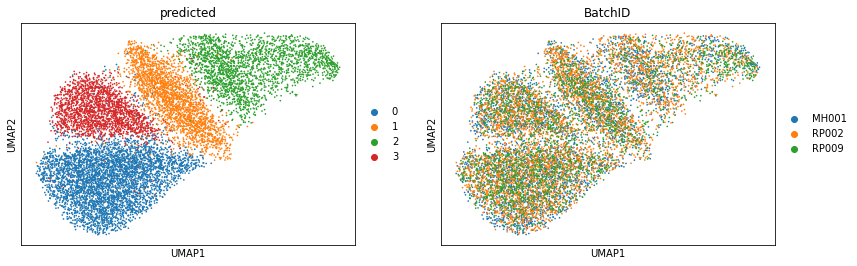

In [19]:
formatting = AnnData(deepcopy(CarDEC.dataset.layers['denoised counts']))
formatting.obs = CarDEC.dataset.obs
sc.pp.normalize_total(formatting)
sc.pp.log1p(formatting)
sc.pp.scale(formatting)

sc.tl.pca(formatting, svd_solver='arpack')
sc.pp.neighbors(formatting, n_neighbors = 15)

res = find_resolution(formatting, 4)
sc.tl.louvain(formatting, resolution = res)
formatting.obs['predicted'] = formatting.obs['louvain'].copy()
sc.tl.umap(formatting)
sc.pl.umap(formatting, color = ["predicted", "BatchID"], return_fig = True)
print("Done")

In [20]:
tmp0=formatting.obs[["predicted","BatchID"]].copy()
tmp0.columns=["denoisedall_predicted","denoisedall_BatchID"]
res0['denoisedall embedding']=tmp0.copy()

## Working with only the highly variable denoised counts

Done


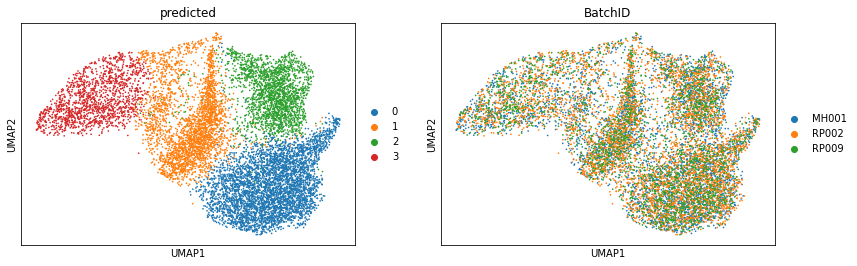

In [21]:
formatting = AnnData(deepcopy(CarDEC.dataset.layers['denoised counts'][:, CarDEC.dataset.var['Variance Type'] == 'HVG']))
formatting.obs = CarDEC.dataset.obs

sc.pp.normalize_total(formatting)
sc.pp.log1p(formatting)
sc.pp.scale(formatting)

sc.tl.pca(formatting, svd_solver='arpack')
sc.pp.neighbors(formatting, n_neighbors = 15)

res = find_resolution(formatting, 4)
sc.tl.louvain(formatting, resolution = res)
formatting.obs['predicted'] = formatting.obs['louvain'].copy()

sc.tl.umap(formatting)
sc.pl.umap(formatting, color = ["predicted", "BatchID"], return_fig = True)
print("Done")

In [22]:
tmp0=formatting.obs[["predicted","BatchID"]].copy()
tmp0.columns=["denoisedHVG_predicted","denoisedHVG_BatchID"]
res0['denoisedHVG embedding']=tmp0.copy()

## Working with only the low variance denoised counts

Done


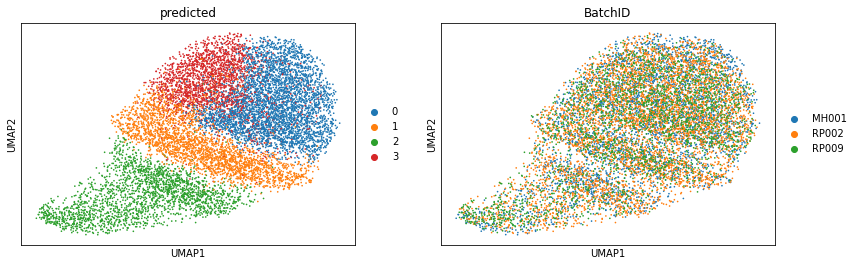

In [23]:
formatting = AnnData(deepcopy(CarDEC.dataset.layers['denoised counts'][:, CarDEC.dataset.var['Variance Type'] == 'LVG']))
formatting.obs = CarDEC.dataset.obs

sc.pp.normalize_total(formatting)
sc.pp.log1p(formatting)
sc.pp.scale(formatting)

sc.tl.pca(formatting, svd_solver='arpack')
sc.pp.neighbors(formatting, n_neighbors = 15)

res = find_resolution(formatting, 4)
sc.tl.louvain(formatting, resolution = res)
formatting.obs['predicted'] = formatting.obs['louvain'].copy()

sc.tl.umap(formatting)
sc.pl.umap(formatting, color = ["predicted", "BatchID"], return_fig = True)
print("Done")

In [24]:
tmp0=formatting.obs[["predicted","BatchID"]].copy()
tmp0.columns=["denoisedLVG_predicted","denoisedLVG_BatchID"]
res0['denoisedLVG embedding']=tmp0.copy()

## Working with the denoised counts on the zscore scale

Done


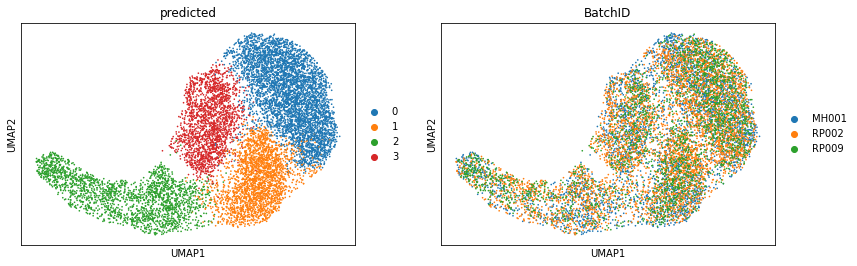

In [25]:
formatting = AnnData(deepcopy(CarDEC.dataset.layers['denoised']))
formatting.obs = CarDEC.dataset.obs

sc.tl.pca(formatting, svd_solver='arpack')
sc.pp.neighbors(formatting, n_neighbors = 15)

res = find_resolution(formatting, 4)
sc.tl.louvain(formatting, resolution = res)
formatting.obs['predicted'] = formatting.obs['louvain'].copy()
sc.tl.umap(formatting)
sc.pl.umap(formatting, color = ["predicted", "BatchID"], return_fig = True)
print("Done")

In [26]:
tmp0=formatting.obs[["predicted","BatchID"]].copy()
tmp0.columns=["zscore_predicted","zscore_BatchID"]
res0['zscore embedding']=tmp0.copy()

In [27]:
res1=list(res0.values())
xx0=[]
for i in res1:
    i.index=CarDEC.dataset.obs_names
    xx0.append(i.iloc[:,:2].copy())

In [28]:
df00=pd.concat(xx0,axis=1)

In [29]:
df00

latent_predicted latent_BatchID prelatent_predicted  \
index                                                                          
CTCTACGCACAGACAG-1-MH001                1          MH001                   0   
ACGCCAGAGATGTAAC-1-MH001                0          MH001                   0   
AGAGTGGGTATAGTAG-1-MH001                3          MH001                   3   
GTATCTTCATCGGAAG-1-MH001                2          MH001                   1   
AACCGCGGTGCGGTAA-1-MH001                2          MH001                   2   
...                                   ...            ...                 ...   
ATCTGCCGTTTAGCTG-1-RP009                2          RP009                   2   
GAACATCGTGTTTGTG-1-RP009                0          RP009                   0   
CAAGGCCTCGACAGCC-1-RP009                0          RP009                   0   
TCGCGTTGTATATGGA-1-RP009                1          RP009                   1   
CTAAGACCACTTACGA-1-RP009                1          RP009                   1   

                         prelatent_BatchID denoisedall_predicted  \
index                                                              
CTCTACGCACAGACAG-1-MH001             MH001                     3   
ACGCCAGAGATGTAAC-1-MH001             MH001                     0   
AGAGTGGGTATAGTAG-1-MH001             MH001                     3   
GTATCTTCATCGGAAG-1-MH001             MH001                     2   
AACCGCGGTGCGGTAA-1-MH001             MH001                     2   
...                                    ...                   ...   
ATCTGCCGTTTAGCTG-1-RP009             RP009                     2   
GAACATCGTGTTTGTG-1-RP009             RP009                     0   
CAAGGCCTCGACAGCC-1-RP009             RP009                     0   
TCGCGTTGTATATGGA-1-RP009             RP009                     1   
CTAAGACCACTTACGA-1-RP009             RP009                     1   

                         denoisedall_BatchID denoisedHVG_predicted  \
index                                                                
CTCTACGCACAGACAG-1-MH001               MH001                     1   
ACGCCAGAGATGTAAC-1-MH001               MH001                     0   
AGAGTGGGTATAGTAG-1-MH001               MH001                     2   
GTATCTTCATCGGAAG-1-MH001               MH001                     1   
AACCGCGGTGCGGTAA-1-MH001               MH001                     3   
...                                      ...                   ...   
ATCTGCCGTTTAGCTG-1-RP009               RP009                     3   
GAACATCGTGTTTGTG-1-RP009               RP009                     0   
CAAGGCCTCGACAGCC-1-RP009               RP009                     0   
TCGCGTTGTATATGGA-1-RP009               RP009                     1   
CTAAGACCACTTACGA-1-RP009               RP009                     1   

                         denoisedHVG_BatchID denoisedLVG_predicted  \
index                                                                
CTCTACGCACAGACAG-1-MH001               MH001                     3   
ACGCCAGAGATGTAAC-1-MH001               MH001                     0   
AGAGTGGGTATAGTAG-1-MH001               MH001                     1   
GTATCTTCATCGGAAG-1-MH001               MH001                     2   
AACCGCGGTGCGGTAA-1-MH001               MH001                     2   
...                                      ...                   ...   
ATCTGCCGTTTAGCTG-1-RP009               RP009                     2   
GAACATCGTGTTTGTG-1-RP009               RP009                     0   
CAAGGCCTCGACAGCC-1-RP009               RP009                     0   
TCGCGTTGTATATGGA-1-RP009               RP009                     1   
CTAAGACCACTTACGA-1-RP009               RP009                     1   

                         denoisedLVG_BatchID zscore_predicted zscore_BatchID  
index                                                                         
CTCTACGCACAGACAG-1-MH001               MH001                3          MH001  
ACGCCAGAGATGTAAC-1-MH001               M

In [30]:
import plotly.express as px
df = df00[['latent_predicted','denoisedall_predicted','denoisedHVG_predicted','denoisedLVG_predicted','zscore_predicted']]
df['latent_predicted']=df['latent_predicted'].astype(int)
#df.latent_predicted.head(10)

/home/xiaoxiang/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
#refer to https://plotly.com/python/colorscales/
fig = px.parallel_categories(df,color="latent_predicted",
                             range_color=[0,4],
                             title="sdfsd",
                             color_continuous_scale=[(0.00, "red"),   (0.25, "red"),
                                                     (0.25, "green"), (0.50, "green"),
                                                     (0.50, "blue"),  (0.75, "blue"),
                                                     (0.75, "yellow"),  (1.00, "yellow")])
fig.update_layout(
    title={
        'text': "The clustering results of CarDEC for monocyte data using different information",
        'y':0.95,
        'x':0.5,
        'font':dict(size=20,color=px.colors.sequential.Viridis[0]),
        'xanchor': 'center',
        'yanchor': 'top'},
 
    coloraxis_colorbar=dict(
    title="Cluster id",
    thicknessmode="pixels", 
    thickness=15,
    lenmode="pixels", 
    len=200,
    yanchor="top", 
    y=0.8,
    #ticks="outside",
    tickvals=[0.5,1.5,2.5,3.5],
    ticktext=["0","1","2","3"],
    #ticksuffix=" bills",
    dtick=5
))
fig.write_html("./CarDEC Results/clusters_different_representation.html")
fig.show()

In [32]:
#?px.parallel_categories
res1=list(res0.values())
df=res1[0].copy()
del df['latent_BatchID']
df['latent_predicted']=df['latent_predicted'].astype(int)
df['louvain_k3']=df['louvain_k3'].astype(int)
df['louvain_k4']=df['louvain_k4'].astype(int)
df['louvain_k5']=df['louvain_k5'].astype(int)
df['louvain_k6']=df['louvain_k6'].astype(int)
df.head(5)

latent_predicted  louvain_k3  louvain_k4  \
index                                                                
CTCTACGCACAGACAG-1-MH001                 1           1           3   
ACGCCAGAGATGTAAC-1-MH001                 0           0           0   
AGAGTGGGTATAGTAG-1-MH001                 3           2           1   
GTATCTTCATCGGAAG-1-MH001                 2           1           2   
AACCGCGGTGCGGTAA-1-MH001                 2           1           2   

                          louvain_k5  louvain_k6  
index                                             
CTCTACGCACAGACAG-1-MH001           1           0  
ACGCCAGAGATGTAAC-1-MH001           2           2  
AGAGTGGGTATAGTAG-1-MH001           0           4  
GTATCTTCATCGGAAG-1-MH001           3           1  
AACCGCGGTGCGGTAA-1-MH001           3           1

In [33]:
fig = px.parallel_categories(df,dimensions=['louvain_k3','latent_predicted','louvain_k4','louvain_k5','louvain_k6'],
                             color="latent_predicted",
                             range_color=[0,4],
                             title="sdfsd",
                             color_continuous_scale=[(0.00, "red"),   (0.25, "red"),
                                                     (0.25, "green"), (0.50, "green"),
                                                     (0.50, "blue"),  (0.75, "blue"),
                                                     (0.75, "yellow"),  (1.00, "yellow")],
                            )
fig.update_layout(
    title={
        'text': "The clustering assignment of carDEC and clustering results with using the embedding",
        'y':0.95,
        'x':0.5,
        'font':dict(size=20,color=px.colors.sequential.Viridis[0]),
        'xanchor': 'center',
        'yanchor': 'top'},
 
    coloraxis_colorbar=dict(
    title="latent_predicted",
    thicknessmode="pixels", 
    thickness=15,
    lenmode="pixels", 
    len=200,
    yanchor="top", 
    y=0.8,
    #ticks="outside",
    tickvals=[0.5,1.5,2.5,3.5],
    ticktext=["0","1","2","3"],
    #ticksuffix=" bills",
    dtick=5
))
fig.write_html("./CarDEC Results/clusters_different_resolution.html")
fig.show()